<a href="https://colab.research.google.com/github/iniola145/March-21/blob/main/Copy_of_March_21st%20i%20dunno%20just%20try%20it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
import os

# 1) Enable mixed precision for faster training + lower memory usage
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision policy:", mixed_precision.global_policy())

# 2) Enable GPU memory growth (avoid OOM errors)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)


Mixed precision policy: <DTypePolicy "mixed_float16">
GPU memory growth enabled.
TensorFlow version: 2.18.0


In [2]:
!pip install kagglehub --upgrade

import kagglehub

# Download the "feature-vector-cassava-disease-v1" variation of CropNet
cropnet_path = kagglehub.model_download("google/cropnet/tensorFlow2/feature-vector-cassava-disease-v1")

print("✅ CropNet (feature-vector) downloaded to:", cropnet_path)
print("📂 Listing files in cropnet_path:")
!ls "{cropnet_path}"



100%|██████████| 5.48k/5.48k [00:00<00:00, 10.6MB/s]



  0%|          | 0.00/1.45M [00:00<?, ?B/s]



  0%|          | 0.00/16.2M [00:00<?, ?B/s]
 69%|██████▉   | 1.00M/1.45M [00:01<00:00, 736kB/s]

  6%|▌         | 1.00M/16.2M [00:01<00:21, 728kB/s]
100%|██████████| 1.45M/1.45M [00:01<00:00, 976kB/s] 


 12%|█▏        | 2.00M/16.2M [00:01<00:10, 1.42MB/s]

 19%|█▊        | 3.00M/16.2M [00:01<00:06, 2.25MB/s]

 25%|██▍       | 4.00M/16.2M [00:01<00:03, 3.26MB/s]

 37%|███▋      | 6.00M/16.2M [00:02<00:01, 5.59MB/s]

 49%|████▉     | 8.00M/16.2M [00:02<00:01, 7.96MB/s]

 62%|██████▏   | 10.0M/16.2M [00:02<00:00, 9.87MB/s]

 74%|███████▍  | 12.0M/16.2M [00:02<00:00, 7.92MB/s]

100%|██████████| 16.2M/16.2M [00:02<00:00, 5.82MB/s]

✅ CropNet (feature-vector) downloaded to: /root/.cache/kagglehub/models/google/cropnet/tensorFlow2/feature-vector-cassava-disease-v1/1
📂 Listing files in cropnet_path:
saved_model.pb	variables


In [3]:
from google.colab import files

# 1) Upload your "kaggle.json" file
files.upload()  # Upload your kaggle.json here

# 2) Move kaggle.json to the correct location and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3) Install Kaggle and download the dataset
!pip install kaggle --upgrade

# Replace "mexwell/crop-diseases-classification" with the correct Kaggle dataset if needed
!kaggle datasets download -d mexwell/crop-diseases-classification

# 4) Unzip
!unzip -q crop-diseases-classification.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mexwell/crop-diseases-classification
License(s): other


In [4]:
import pandas as pd
import os

# Path to your "Data" folder (adjust if needed)
BASE_DIR = '/content/Data'
CSV_PATH = os.path.join(BASE_DIR, 'train.csv')
IMG_DIR = os.path.join(BASE_DIR, 'train_images')

# Load CSV
df = pd.read_csv(CSV_PATH)
print("Initial DataFrame size:", len(df))

# Create full image path column
df['img_path'] = df['image_id'].apply(lambda x: os.path.join(IMG_DIR, x))

# Filter out rows where the image file does not exist
df = df[df['img_path'].apply(os.path.exists)].reset_index(drop=True)
print("After filtering missing images:", len(df))

# Check class distribution
print(df['label'].value_counts())


Initial DataFrame size: 21397
After filtering missing images: 17938
label
3    11027
4     2166
2     1993
1     1831
0      921
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split

# Let's do a 70% (train), 20% (val), 10% (test) split
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['label'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.3333,  # 1/3 of 30% ~ 10% total
    stratify=temp_df['label'],
    random_state=42
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))


Train size: 12556
Val size: 3588
Test size: 1794


In [14]:
import tensorflow as tf
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import pandas as pd

# Define image size (adjust if needed)
IMG_SIZE = (224, 224)

# -----------------------------
# Define Augmentation Transforms
# -----------------------------
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=30, p=0.5),
    # Use CoarseDropout without extra parameters.
    A.CoarseDropout(p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# -----------------------------
# Define the Preprocessing Function
# -----------------------------
def load_and_preprocess(path, label, training=False):
    def _augment(image_path):
        # Convert tensor to numpy and decode the string.
        path_str = image_path.numpy().decode("utf-8")
        # Read image using OpenCV (BGR by default)
        image = cv2.imread(path_str)
        if image is None:
            # If image not found, create a blank image.
            image = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Resize image
        image = cv2.resize(image, IMG_SIZE)
        # Apply augmentation transforms
        if training:
            augmented = train_transform(image=image)
        else:
            augmented = val_transform(image=image)
        # Retrieve the transformed image.
        out_img = augmented["image"]
        # If the output is a torch tensor, convert it to numpy.
        if hasattr(out_img, "cpu"):
            out_img = out_img.cpu().numpy()
        else:
            out_img = np.array(out_img)
        # If the image is in (C, H, W) format (channels first), transpose to (H, W, C).
        if out_img.ndim == 3 and out_img.shape[0] in [1, 3]:
            out_img = np.transpose(out_img, (1, 2, 0))
        return out_img

    # Wrap the augment function so it can be used in a tf.data pipeline.
    image = tf.py_function(func=_augment, inp=[path], Tout=tf.float32)
    # Set static shape for TensorFlow.
    image.set_shape((IMG_SIZE[0], IMG_SIZE[1], 3))
    return image, label

# -----------------------------
# Build the Dataset from a DataFrame
# -----------------------------
def df_to_dataset(dataframe, training=False):
    paths = dataframe['img_path'].values
    labels = dataframe['label'].values.astype('int32')
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(dataframe), reshuffle_each_iteration=True)
    ds = ds.map(lambda x, y: load_and_preprocess(x, y, training=training),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(16)  # Adjust batch size as needed.
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# -----------------------------
# Example Usage
# -----------------------------
# For demonstration, create a dummy DataFrame.
data = {
    'img_path': ['/content/sample1.jpg', '/content/sample2.jpg'],  # Replace with your actual image paths.
    'label': [0, 1]
}
df = pd.DataFrame(data)

# Create datasets for training and validation.
train_ds = df_to_dataset(df, training=True)
val_ds = df_to_dataset(df, training=False)

# Iterate through one batch and print the shapes.
for images, labels in train_ds.take(1):
    print("Batch image shape:", images.shape)
    print("Labels:", labels)


Batch image shape: (2, 224, 224, 3)
Labels: tf.Tensor([1 0], shape=(2,), dtype=int32)


In [15]:
import pandas as pd
from sklearn.utils import resample

# Assume train_df is your preprocessed DataFrame with 'img_path' and 'label' columns.
# For example:
# train_df = pd.read_csv('your_preprocessed_train.csv')

# Display original class distribution.
print("Original class distribution:")
print(train_df['label'].value_counts())

# Calculate the maximum count among classes.
class_counts = train_df['label'].value_counts()
max_count = class_counts.max()

# Oversample each class to match the majority class.
oversampled_dfs = []
for cls in class_counts.index:
    cls_df = train_df[train_df['label'] == cls]
    cls_oversampled = resample(cls_df,
                               replace=True,
                               n_samples=max_count,
                               random_state=42)
    oversampled_dfs.append(cls_oversampled)

# Concatenate oversampled DataFrames to create a balanced DataFrame.
train_df_balanced = pd.concat(oversampled_dfs).reset_index(drop=True)

print("\nBalanced class distribution:")
print(train_df_balanced['label'].value_counts())


Original class distribution:
label
3    7718
4    1516
2    1395
1    1282
0     645
Name: count, dtype: int64

Balanced class distribution:
label
3    7718
4    7718
2    7718
1    7718
0    7718
Name: count, dtype: int64


In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetV2S

# ---- EfficientNetV2-S Feature Extractor ----
effnet = EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_shape=(224, 224, 3)
)
effnet.trainable = False  # Freeze to use as feature extractor

# ---- CropNet Feature Layer (feature-vector-cassava-disease-v1) ----
class CropNetFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, model_path, **kwargs):
        super(CropNetFeatureLayer, self).__init__(**kwargs)
        self.model = tf.saved_model.load(model_path)

        # Test call on dummy input
        dummy_input = tf.random.uniform((1, 224, 224, 3), dtype=tf.float32)
        try:
            _ = self.model(image=dummy_input, training=False)
            print("✅ CropNet model is callable with 'image' + 'training' args.")
        except Exception as e:
            print("❌ CropNet model call failed:", e)
            raise ValueError("Cannot call CropNet model with expected signature.")

    def call(self, inputs, training=False):
        inputs = tf.cast(inputs, tf.float32)
        # CropNet expects a dict with key='image'
        output = self.model(image=inputs, training=False)
        return output

cropnet_layer = CropNetFeatureLayer(cropnet_path)

# ---- Combined Model ----
input_tensor = layers.Input(shape=(224, 224, 3))
feat_effnet  = effnet(input_tensor)         # EfficientNetV2-S features
feat_cropnet = cropnet_layer(input_tensor)    # CropNet features

# Concatenate both feature vectors
combined_features = layers.Concatenate()([feat_effnet, feat_cropnet])

# Define the number of classes (adjust this to your dataset)
num_classes = 5

# Lightweight Classifier with enhanced capacity and L2 regularization
# First Dense layer: increase neurons and add L2 regularization
x = layers.Dense(1024, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4))(combined_features)
x = layers.Dropout(0.3)(x)
# Second Dense layer: further feature processing with regularization
x = layers.Dense(512, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
# Final Dense layer for classification; using float32 because of mixed precision
outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

model = models.Model(inputs=input_tensor, outputs=outputs, name="CassavaDiseaseModel")

model.summary()


✅ CropNet model is callable with 'image' + 'training' args.


Model: "CassavaDiseaseModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_9 (Cast)             │ (None, 224, 224, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ crop_net_feature_layer_2  │ (None, 1280)           │              0 │ cast_9[0][0]           │
│ (CropNetFeatureLayer)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetv2-s          │ (None, 1280)           │     20,331,360 │ input_layer_5[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_10 (Cast)            │ (None, 1280)           │              0 │ crop_net_feature_laye… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 2560)           │              0 │ efficientnetv2-s[0][0… │
│ (Concatenate)             │                        │                │ cast_10[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1024)           │      2,622,464 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 1024)           │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 512)            │        524,800 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 512)            │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_11 (Cast)            │ (None, 512)            │              0 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 5)              │          2,565 │ cast_11[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,481,189 (89.57 MB)

 Trainable params: 3,149,829 (12.02 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [ ]:
from keras.optimizers import AdamW  # or use experimental if necessary
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-5)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Save in the native Keras format by using the .keras extension.
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

EPOCHS = 25

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67s/step - accuracy: 0.0000e+00 - loss: 1.6554
Epoch 1: val_loss improved from inf to 1.36335, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 87s 87s/step - accuracy: 0.0000e+00 - loss: 1.6554 - val_accuracy: 0.5000 - val_loss: 1.3633 - learning_rate: 0.0010
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5000 - loss: 1.1181
Epoch 2: val_loss improved from 1.36335 to 0.96628, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 1.1181 - val_accuracy: 0.5000 - val_loss: 0.9663 - learning_rate: 0.0010
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.0000e+00 - loss: 1.1923
Epoch 3: val_loss did not improve from 0.96628
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step - accuracy: 0.0000e+00 - loss: 1.1923 - val_accuracy: 0.5000 - val_loss: 1.4860 - learning_rate: 0.0010
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5000 - loss: 1.2178
Epoch 4: val_loss improved

In [ ]:
# Fine tuning cell: Unfreeze part of EfficientNetV2-S and fine tune the model

# Unfreeze the EfficientNetV2-S model for fine-tuning
effnet.trainable = True

# Optionally, freeze the early layers to avoid overfitting (e.g., freeze all layers except the last 20)
for layer in effnet.layers[:-20]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
from keras.optimizers import AdamW
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine tuning configuration
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS = EPOCHS + FINE_TUNE_EPOCHS  # Continue training from the previous epoch count

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=TOTAL_EPOCHS,
    initial_epoch=EPOCHS,  # Start from the last epoch of previous training
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weight
)


Epoch 26/35
    785/Unknown 182s 93ms/step - accuracy: 0.8824 - loss: 0.4209
Epoch 26: val_loss did not improve from 0.37604
785/785 ━━━━━━━━━━━━━━━━━━━━ 217s 137ms/step - accuracy: 0.8824 - loss: 0.4209 - val_accuracy: 0.8737 - val_loss: 0.3870 - learning_rate: 1.0000e-04
Epoch 27/35
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8933 - loss: 0.3448
Epoch 27: val_loss did not improve from 0.37604
785/785 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - accuracy: 0.8933 - loss: 0.3448 - val_accuracy: 0.8715 - val_loss: 0.3912 - learning_rate: 1.0000e-04
Epoch 28/35
784/785 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8954 - loss: 0.3311
Epoch 28: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 28: val_loss did not improve from 0.37604
785/785 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - accuracy: 0.8954 - loss: 0.3311 - val_accuracy: 0.8721 - val_loss: 0.3970 - learning_rate: 1.0000e-04
Epoch 29/35
784/785 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9009 - loss: 0

113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 217ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.76      0.66        92
           1       0.73      0.83      0.77       183
           2       0.80      0.79      0.80       199
           3       0.98      0.92      0.95      1103
           4       0.70      0.73      0.72       217

    accuracy                           0.87      1794
   macro avg       0.76      0.81      0.78      1794
weighted avg       0.88      0.87      0.87      1794

Test Accuracy: 0.8685
Test Precision: 0.8794
Test Recall: 0.8685
Test F1-Score: 0.8725


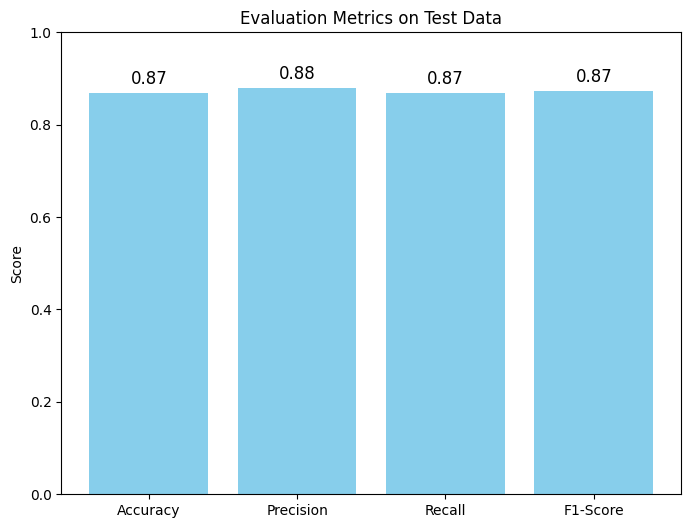

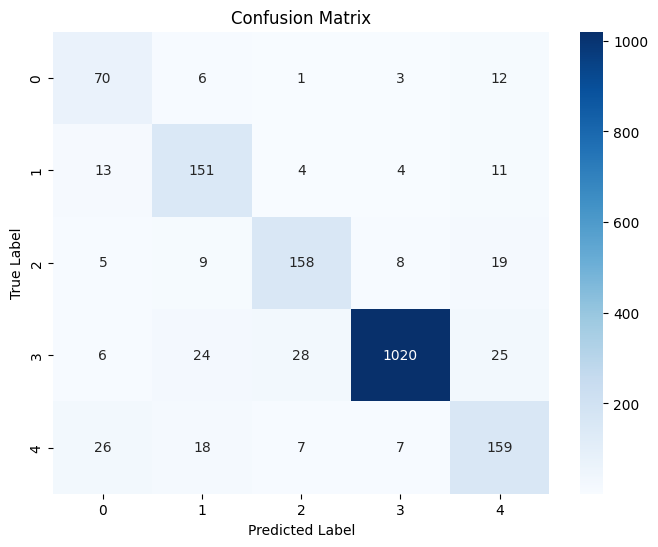

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Generate predictions on the test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print("Classification Report:")
print(classification_report(y_true, y_pred))

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Bar chart of evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, values, color='skyblue')
plt.ylim(0, 1)
plt.title('Evaluation Metrics on Test Data')

# Annotate bars with metric values
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{value:.2f}", ha='center', fontsize=12)

plt.ylabel('Score')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - accuracy: 0.8716 - loss: 0.3785
Test Loss: 0.3889, Test Accuracy: 0.8685


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


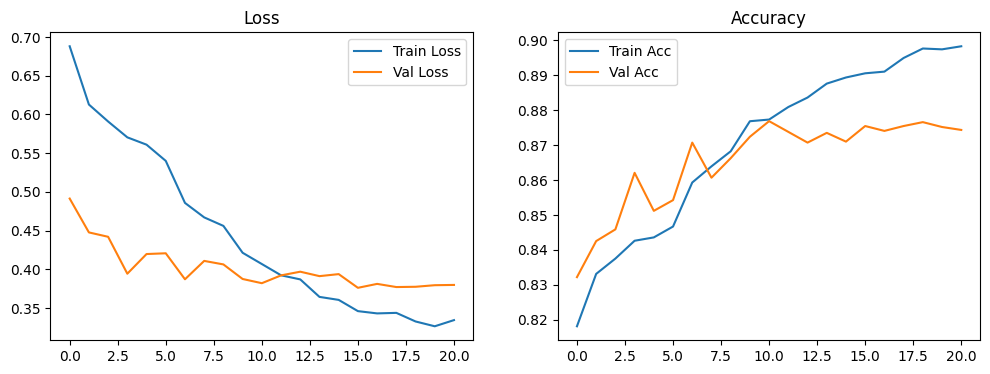

Final model saved as final_cassava_disease_model.h5


In [ ]:
import matplotlib.pyplot as plt

# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()

# Optional: Save final model
model.save("final_cassava_disease_model.h5")
print("Final model saved as final_cassava_disease_model.h5")
